<a href="https://www.kaggle.com/code/mh0386/logistic-regression-from-scratch?scriptVersionId=241976657" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from collections import Counter
from pathlib import Path
from sys import float_info
from typing import Literal, Callable
import matplotlib.pyplot as plt
import numpy as np
from cv2 import flip, getRotationMatrix2D, resize, warpAffine
from kagglehub import dataset_download
from numpy import float64, uint, array
from numpy.typing import NDArray
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split

# Loading Data

In [2]:
path: str = dataset_download(handle="rashikrahmanpritom/covid-wwo-pneumonia-chest-xray")

covid_without_PNEUMONIA_train_path = Path(f"{path}/Data/train/covid_without_PNEUMONIA")
covid_with_PNEUMONIA_train_path = Path(f"{path}/Data/train/covid_with_PNEUMONIA")

covid_without_PNEUMONIA_test_path = Path(f"{path}/Data/test/covid_without_PNEUMONIA")
covid_with_PNEUMONIA_test_path = Path(f"{path}/Data/test/covid_with_PNEUMONIA")

In [3]:
covid_without_PNEUMONIA_path: list[Path] = [
    covid_without_PNEUMONIA_train_path,
    covid_without_PNEUMONIA_test_path,
]

covid_with_PNEUMONIA_path: list[Path] = [
    covid_with_PNEUMONIA_train_path,
    covid_with_PNEUMONIA_test_path,
]

In [4]:
np.random.seed(seed=42)

In [5]:
label2category: dict[str, int] = {
    "covid_without_PNEUMONIA": 0,
    "covid_with_PNEUMONIA": 1,
}
category2label: dict[int, str] = {
    0: "covid_without_PNEUMONIA",
    1: "covid_with_PNEUMONIA",
}

In [6]:
data: list[dict[str, str]] = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob(pattern="*.jpeg"):
        data.append({"img_path": str(object=img), "label": "covid_without_PNEUMONIA"})

for path in covid_with_PNEUMONIA_path:
    for img in path.glob(pattern="*.jpeg"):
        data.append({"img_path": str(object=img), "label": "covid_with_PNEUMONIA"})

In [7]:
def counter_label(data: list[dict[str, str]], key: str) -> Counter[str]:
    return Counter([record[key] for record in data])

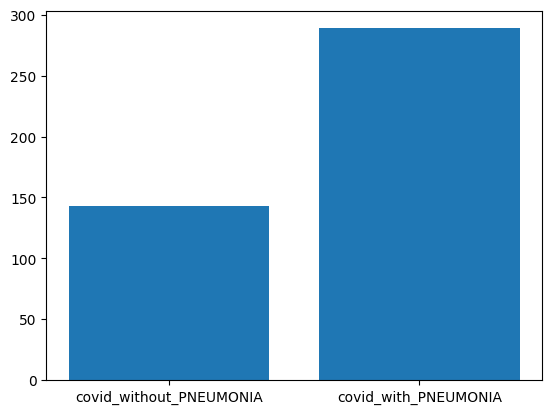

In [8]:
img_l_counter: Counter[str] = counter_label(data=data, key="label")

keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

plt.bar(x=keys, height=values)
plt.show()

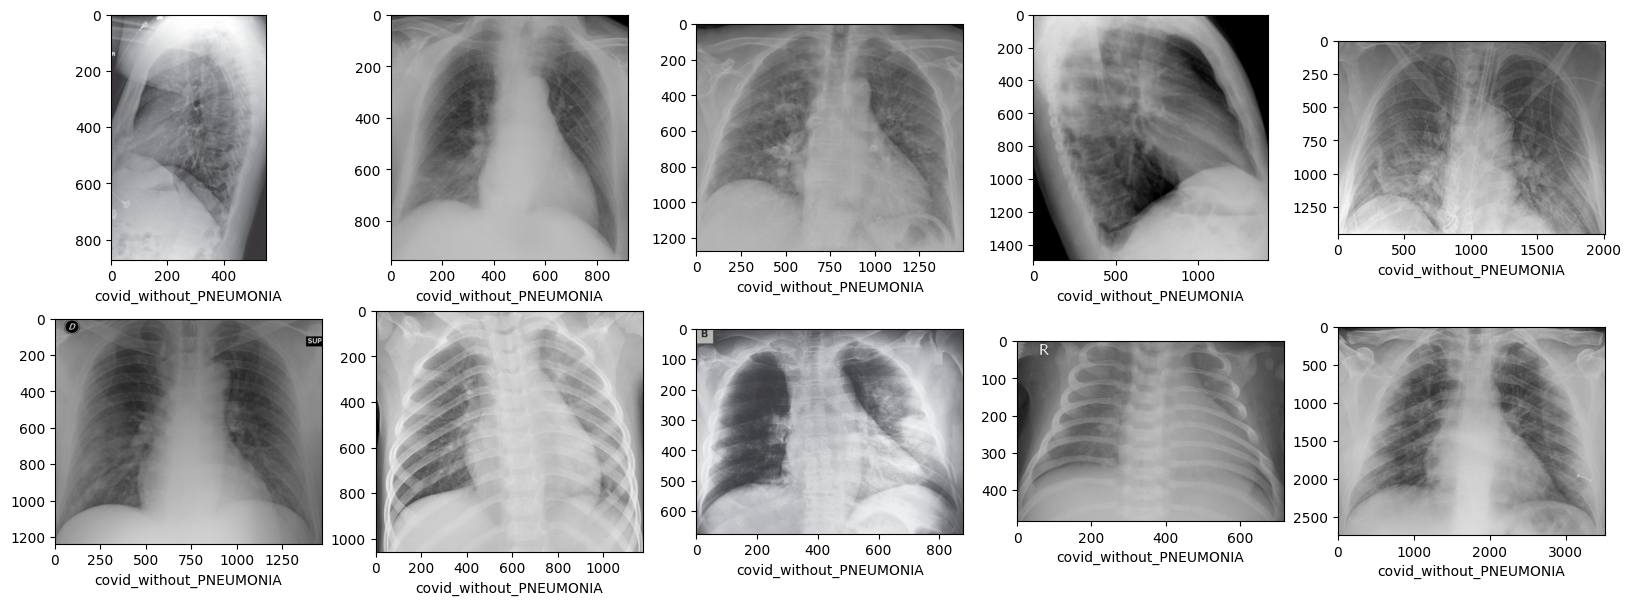

In [9]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(iterable=data[:10]):
    path: str = data_["img_path"]
    label: str = data_["label"]
    plt.subplot(2, 5, i + 1)
    img: NDArray[uint] = plt.imread(fname=path)
    plt.imshow(X=img)
    plt.xlabel(xlabel=label)

plt.show()

In [10]:
def rotating(
    image: NDArray[float64],
    angle: int = 90,
    scale: float = 1.0,
) -> NDArray[float64]:
    # Get the dimensions of the image
    h: int = image.shape[:2][0]
    w: int = image.shape[:2][1]
    # Compute the center of the image
    center: tuple[float, float] = (w / 2.0, h / 2.0)
    # Perform the rotation
    M: NDArray[float64] = array(
        object=getRotationMatrix2D(center=center, angle=angle, scale=scale),
        dtype=float64,
    )
    rotated: NDArray[float64] = array(
        object=warpAffine(src=image, M=M, dsize=(w, h)), dtype=float64
    )
    return rotated

In [11]:
def fliping(image: NDArray[float64], flip_code: int) -> NDArray[float64]:
    # Flip the image horizontally, vertically, or both
    # flip_code = 0: flip vertically
    # flip_code > 0: flip horizontally
    # flip_code < 0: flip vertically and horizontally
    return array(object=flip(src=image, flipCode=flip_code), dtype=float64)

In [12]:
def resizing(image: NDArray[float64], size: tuple[int, int]) -> NDArray[float64]:
    return array(object=resize(src=image, dsize=size), dtype=float64)

In [13]:
images_array: list[NDArray[float64]] = []
images_label: list[str] = []
IMG_SIZE: tuple[Literal[100], Literal[100]] = (100, 100)

In [14]:
%time

for data_ in data:
    category: int = label2category[data_["label"]]
    img: NDArray[float64] = plt.imread(fname=data_["img_path"])
    if category == 0:
        random_angle: int = np.random.choice(a=[90, 180, 270])
        random_flip: int = np.random.choice(a=[-1, 0, 1])
        for i in range(2):
            img_rotate: NDArray[float64] = rotating(image=img, angle=random_angle)
            img_flip: NDArray[float64] = fliping(
                image=img_rotate, flip_code=random_flip
            )
            img_resize: NDArray[float64] = resizing(image=img_flip, size=IMG_SIZE)
            images_array.append(img_resize)
            images_label.append(data_["label"])
    else:
        img_resize: NDArray[float64] = resizing(image=img, size=IMG_SIZE)
        images_array.append(img_resize)
        images_label.append(data_["label"])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 273 µs


In [15]:
# plot number of samples in each class
# Assuming 'data' is your numpy array with class labels

unique_elements = np.unique(ar=images_label, return_counts=True)
classes = unique_elements[0]
counts = unique_elements[1]

print(f"Classes: {classes}")
print(f"Counts: {counts}")

Classes: ['covid_with_PNEUMONIA' 'covid_without_PNEUMONIA']
Counts: [289 286]


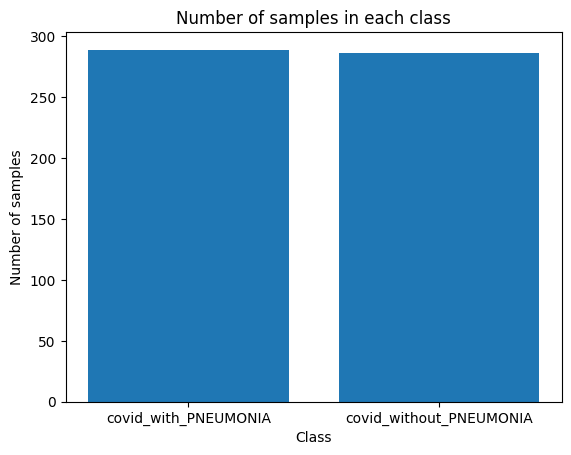

In [16]:
# Plotting the bar graph
plt.bar(x=classes, height=counts)
plt.xlabel(xlabel="Class")
plt.ylabel(ylabel="Number of samples")
plt.title(label="Number of samples in each class")
plt.show()

In [17]:
images_array: NDArray[float64] = np.array(object=images_array)
images_label: NDArray = np.array(object=images_label)

print(f"shape of images array: {images_array.shape}, dtype: {images_array.dtype}")
print(f"shape of images label: {images_label.shape}, dtype: {images_label.dtype}")

shape of images array: (575, 100, 100, 3), dtype: float64
shape of images label: (575,), dtype: <U23


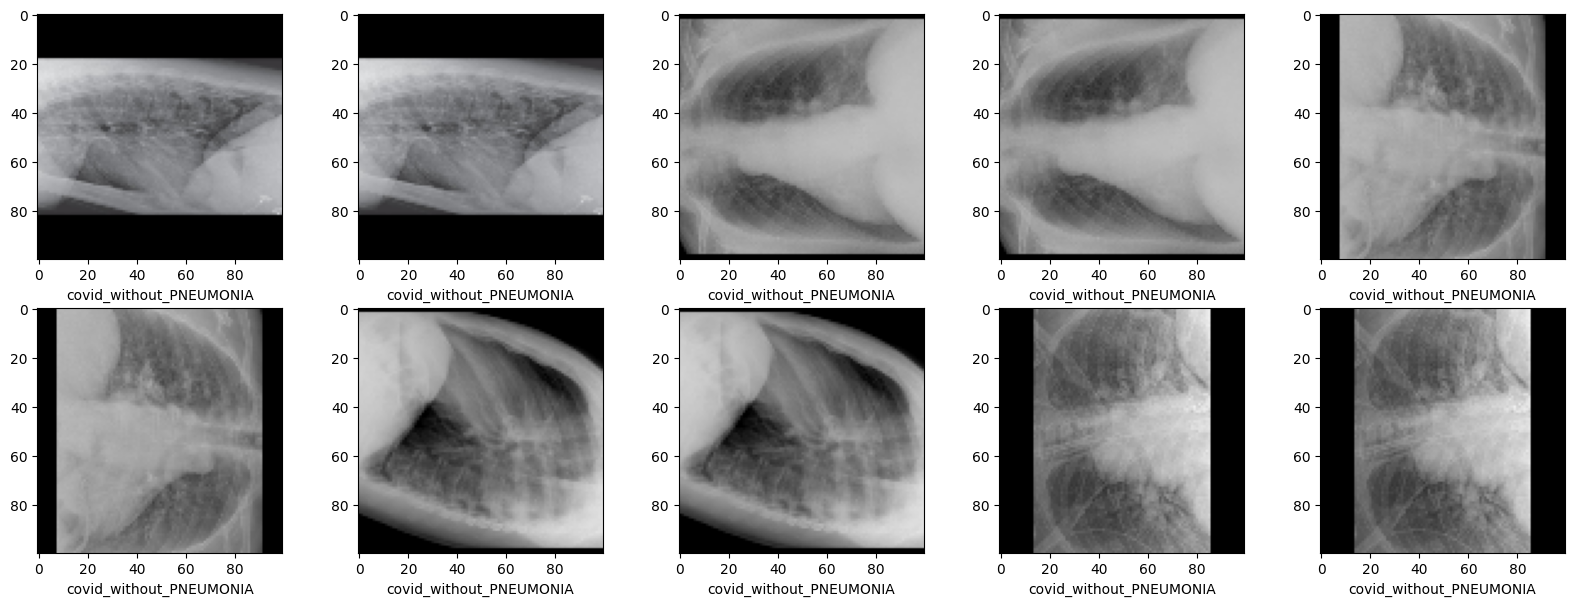

In [18]:
plt.figure(figsize=(20, 7))

for i, data_ in enumerate(iterable=images_array[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X=data_.astype(uint))
    plt.xlabel(xlabel=images_label[i])

plt.show()

In [19]:
images_label: NDArray[uint] = np.where(images_label == "covid_without_PNEUMONIA", 0, 1)

# Feature Extraction


In [20]:
def calculate_centroid(block: NDArray[float64]) -> tuple[float64, float64, float64]:
    """Calculate the centroid of a 3D matrix"""
    rows: int = block.shape[0]
    cols: int = block.shape[1]
    dep: int = block.shape[2]
    x_centroid: float = 0.0
    y_centroid: float = 0.0
    z_centroid: float = 0.0
    for i in range(rows):
        for j in range(cols):
            for k in range(dep):
                x_centroid += i * block[i, j, k]
                y_centroid += j * block[i, j, k]
                z_centroid += k * block[i, j, k]
    total: float64 = np.sum(a=block)
    return x_centroid / total, y_centroid / total, z_centroid / total

In [21]:
def extract_features_with_centroid(
    image: NDArray[float64],
    block_size: int = 50,
) -> NDArray[float64]:
    features: NDArray[float64] = np.zeros(
        shape=(100 // block_size, 100 // block_size, 3)
    )
    for i in range(0, 100, block_size):
        for j in range(0, 100, block_size):
            block: NDArray[float64] = image[i : i + block_size, j : j + block_size]
            centroid: tuple[float64, float64, float64] = calculate_centroid(block=block)
            x_centroid: float64 = centroid[0]
            y_centroid: float64 = centroid[1]
            z_centroid: float64 = centroid[2]
            features[int(i / block_size), int(j / block_size), 0] = x_centroid
            features[int(i / block_size), int(j / block_size), 1] = y_centroid
            features[int(i / block_size), int(j / block_size), 2] = z_centroid
    return features

In [22]:
split: list[NDArray] = train_test_split(
    images_array,
    images_label,
    test_size=0.3,
    random_state=42,
)
x_train: NDArray[float64] = split[0]
x_test: NDArray[float64] = split[1]
y_train: NDArray[uint] = split[2]
y_test: NDArray[uint] = split[3]

In [23]:
print(f"train input shape: {x_train.shape}, with type: {x_train.dtype}")
print(f"train output shape: {y_train.shape}, with type: {y_train.dtype}")
print(f"test input shape: {x_test.shape}, with type: {x_test.dtype}")
print(f"test output shape: {y_test.shape}, with type: {y_test.dtype}")

train input shape: (402, 100, 100, 3), with type: float64
train output shape: (402,), with type: int64
test input shape: (173, 100, 100, 3), with type: float64
test output shape: (173,), with type: int64


In [24]:
%time

train_features_with_centroid: NDArray[float64] = np.nan_to_num(
    x=np.array(
        object=[extract_features_with_centroid(image=image) for image in x_train]
    )
)

test_features_with_centroid: NDArray[float64] = np.nan_to_num(
    x=np.array(object=[extract_features_with_centroid(image=image) for image in x_test])
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [25]:
train_features_with_centroid.shape, test_features_with_centroid.shape

((402, 2, 2, 3), (173, 2, 2, 3))

In [26]:
train_features_with_centroid: NDArray[float64] = train_features_with_centroid.reshape(
    train_features_with_centroid.shape[0], -1
)

test_features_with_centroid: NDArray[float64] = test_features_with_centroid.reshape(
    test_features_with_centroid.shape[0], -1
)

In [27]:
train_features_with_centroid.shape, test_features_with_centroid.shape

((402, 12), (173, 12))

# Model


In [28]:
class LogisticRegression:
    def __init__(
        self,
        lr: float = 0.01,
        num_iter: int = 1000,
        verbose: bool = False,
    ) -> None:
        self.lr: float = lr
        self.num_iter: int = num_iter
        self.verbose: bool = verbose
        self.weights: NDArray[float64] = np.array(object=[])
        self.bias: float64 = float64(0.0)
        self.x: NDArray[float64] = np.array(object=[])
        self.y: NDArray[uint] = np.array(object=[])
        self.classes_ = None
        self.m: int = 0
        self.n: int = 0
        self.losses: list[float64] = []
        self.accuracies: list[float64] = []

    def gradient_descent(self) -> None:
        y_hat: NDArray[float64] = self.predict(x=self.x)
        dw: NDArray[float64] = (1.0 / self.m) * np.dot(a=self.x.T, b=(y_hat - self.y))
        db: float64 = (1.0 / self.m) * np.sum(a=y_hat - self.y)
        self.weights -= self.lr * dw
        self.bias -= self.lr * db

    def predict(self, x: NDArray[float64]) -> NDArray[float64]:
        z: NDArray[float64] = np.dot(a=x, b=self.weights) + self.bias
        return 1.0 / (1.0 + np.exp(-z))

    def plot(self) -> None:
        plt.plot(self.losses)
        plt.plot(self.accuracies)
        plt.xlabel(xlabel="Number of iterations")
        plt.ylabel(ylabel="Loss")
        plt.legend(["Loss", "Accuracy"])
        plt.show()

    def loss(self) -> None:
        y_hat: NDArray[float64] = self.predict(x=self.x)
        self.losses.append(
            -np.mean(
                a=self.y * np.log(y_hat + float_info.min)
                + (1 - self.y) * np.log(1 - y_hat + float_info.min)
            )
        )

    def accuracy(self) -> None:
        y_hat: NDArray[float64] = self.predict(x=self.x)
        acc: float64 = np.mean(y_hat.round() == self.y)
        self.accuracies.append(acc)

    def fit(self, x: NDArray[float64], y: NDArray[uint]) -> None:
        self.x = x
        self.y = y
        best_loss: float64 = float64(float_info.max)
        patience: int = 5
        self.m = x.shape[0]
        self.n = x.shape[1]
        self.weights = np.random.rand(self.n)
        self.bias = float64(np.random.rand())
        for _ in range(self.num_iter):
            self.gradient_descent()
            self.loss()
            self.accuracy()
            if self.losses[-1] < best_loss:
                best_loss = self.losses[-1]
                patience = 5
            else:
                patience -= 1
                if patience == 0:
                    break
        if self.verbose:
            print(f"\nFinal Loss: {self.losses[-1]}")
            print(f"Final Accuracy: {self.accuracies[-1]}")

    def eval(self, x: NDArray[float64], y: NDArray[uint]) -> None:
        self.x = x
        self.y = y
        self.accuracy()
        if self.verbose:
            y_hat: NDArray[float64] = self.predict(x=self.x)
            print(f"Accuracy: {self.accuracies[-1]}")
            print(f"Loss: {self.losses[-1]}")
            print(f"F1 Score: {f1_score(y_true=self.y, y_pred=y_hat.round())}")
            print(f"Precision: {precision_score(y_true=self.y, y_pred=y_hat.round())}")
            print(f"Recall: {recall_score(y_true=self.y, y_pred=y_hat.round())}")

In [29]:
model = LogisticRegression(verbose=True)

In [30]:
np.unique(ar=y_train), np.unique(ar=y_test)

(array([0, 1]), array([0, 1]))

In [31]:
train_features_with_centroid: NDArray[float64] = (
    train_features_with_centroid - train_features_with_centroid.mean()
) / train_features_with_centroid.std()


test_features_with_centroid: NDArray[float64] = (
    test_features_with_centroid - test_features_with_centroid.mean()
) / test_features_with_centroid.std()

In [32]:
model.fit(x=train_features_with_centroid, y=y_train)


Final Loss: 0.5993205391012152
Final Accuracy: 0.763681592039801


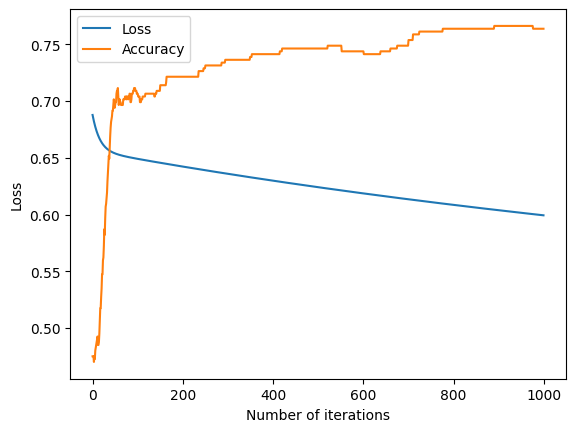

In [33]:
model.plot()

In [34]:
model.eval(x=train_features_with_centroid, y=y_train)

Accuracy: 0.763681592039801
Loss: 0.5993205391012152
F1 Score: 0.8118811881188119
Precision: 0.6996587030716723
Recall: 0.9669811320754716


In [35]:
model.eval(x=test_features_with_centroid, y=y_test)

Accuracy: 0.7109826589595376
Loss: 0.5993205391012152
F1 Score: 0.7524752475247525
Precision: 0.608
Recall: 0.987012987012987


In [36]:
print(
    classification_report(
        y_true=y_test,
        y_pred=model.predict(x=test_features_with_centroid).round(),
    )
)

              precision    recall  f1-score   support

           0       0.98      0.49      0.65        96
           1       0.61      0.99      0.75        77

    accuracy                           0.71       173
   macro avg       0.79      0.74      0.70       173
weighted avg       0.81      0.71      0.70       173



In [37]:
x_train.shape

(402, 100, 100, 3)

In [38]:
y_train.shape

(402,)

# Particle Swarm Optimization


In [39]:
tries: list[NDArray[float64]] = []

In [40]:
class Particle:
    def __init__(self, bounds: list[tuple[int | float, int | float]]) -> None:
        self.position: NDArray[float64] = np.array(
            object=[np.random.uniform(low=b[0], high=b[1]) for b in bounds]
        )
        self.velocity: NDArray[float64] = np.array(
            object=[
                np.random.uniform(low=-abs(b[1] - b[0]), high=abs(b[1] - b[0]))
                for b in bounds
            ]
        )
        self.best_position: NDArray[float64] = self.position.copy()
        self.best_fitness: float = float_info.max
        self.fitness: float = float_info.max

In [41]:
def update_velocity(
    particle: Particle,
    global_best_position: NDArray[float64],
    w: float = 0.5,
    c1: float = 1.0,
    c2: float = 2.0,
) -> None:
    inertia: NDArray[float64] = w * particle.velocity
    cognitive: NDArray[float64] = (
        c1 * np.random.random() * (particle.best_position - particle.position)
    )
    social: NDArray[float64] = (
        c2 * np.random.random() * (global_best_position - particle.position)
    )
    particle.velocity = inertia + cognitive + social

In [42]:
def update_position(
    particle: Particle,
    bounds: list[tuple[int | float, int | float]],
) -> None:
    particle.position += particle.velocity
    # Ensure the particle's position is within the bounds
    for i in range(len(bounds)):
        if particle.position[i] < bounds[i][0]:
            particle.position[i] = bounds[i][0]
        elif particle.position[i] > bounds[i][1]:
            particle.position[i] = bounds[i][1]

In [43]:
def objective_function(subset: NDArray[float64]) -> float:
    tries.append(subset)
    print(f"\tTrying Subset: {round(number=subset[0])}, LR: {subset[1]}")
    X_train_subset: NDArray[float64] = train_features_with_centroid[
        :, : round(number=subset[0])
    ]
    X_test_subset: NDArray[float64] = test_features_with_centroid[
        :, : round(number=subset[0])
    ]
    model = LogisticRegression(lr=subset[1])
    model.fit(x=X_train_subset, y=y_train)
    model.eval(x=X_test_subset, y=y_test)
    y_hat: NDArray[float64] = model.predict(x=X_test_subset)
    return -float(f1_score(y_true=y_test, y_pred=y_hat.round()))

In [44]:
def pso(
    objective_function: Callable[[NDArray[float64]], float],
    bounds: list[tuple[int | float, int | float]],
    num_particles: int,
    max_iter: int,
) -> tuple[NDArray[float64], float]:
    swarm: list[Particle] = [Particle(bounds=bounds) for _ in range(num_particles)]
    global_best_position = np.zeros(shape=len(bounds))
    global_best_fitness: float = float_info.max
    for iteration in range(max_iter):
        for particle in swarm:
            particle.fitness = objective_function(particle.position)
            if particle.fitness < particle.best_fitness:
                particle.best_fitness = particle.fitness
                particle.best_position = particle.position.copy()
            if particle.fitness < global_best_fitness:
                global_best_fitness = particle.fitness
                global_best_position: NDArray[float64] = particle.position.copy()
        for particle in swarm:
            update_velocity(
                particle=particle, global_best_position=global_best_position
            )
            update_position(particle=particle, bounds=bounds)
        print(f"Iteration {iteration + 1}/{max_iter}")
        print(f"Global Best Fitness: {-global_best_fitness}")
        print(f"Global Best Position: {global_best_position}")
    return global_best_position, -global_best_fitness


In [45]:
best: tuple[NDArray[float64], float] = pso(
    objective_function=objective_function,
    bounds=[(2, 12), (0.01, 0.99)],
    num_particles=100,
    max_iter=100,
)
best_position: NDArray[float64] = best[0]
best_fitness: float = best[1]

print("Best position:", best_position)
print("Best fitness:", best_fitness)

	Trying Subset: 2, LR: 0.4940158408797659
	Trying Subset: 9, LR: 0.7165211257670867
	Trying Subset: 7, LR: 0.6336059658221774
	Trying Subset: 12, LR: 0.487007309900266
	Trying Subset: 6, LR: 0.6422012947899536
	Trying Subset: 4, LR: 0.4992095122870573
	Trying Subset: 2, LR: 0.9846595005813942
	Trying Subset: 11, LR: 0.7427643984194656
	Trying Subset: 8, LR: 0.5708466197874216
	Trying Subset: 5, LR: 0.1970928105273391
	Trying Subset: 6, LR: 0.3967976374732828
	Trying Subset: 3, LR: 0.214740343263053
	Trying Subset: 5, LR: 0.29938477665055996
	Trying Subset: 3, LR: 0.7047327769719163
	Trying Subset: 6, LR: 0.2610828047225689
	Trying Subset: 2, LR: 0.6253365266496633
	Trying Subset: 6, LR: 0.059753160418609
	Trying Subset: 8, LR: 0.43970464055772523
	Trying Subset: 4, LR: 0.9722040705443205
	Trying Subset: 5, LR: 0.04805803974083474
	Trying Subset: 5, LR: 0.8213116237118369
	Trying Subset: 7, LR: 0.8351826135117417
	Trying Subset: 9, LR: 0.14558603056944533
	Trying Subset: 9, LR: 0.050246

In [46]:
tries: NDArray[float64] = np.array(object=tries)

In [47]:
tries[:, 0] = np.round(a=tries[:, 0])
subsets: NDArray[float64] = np.unique(ar=tries[:, 0])
lrs: NDArray[float64] = np.unique(ar=tries[:, 1])

In [48]:
subsets, lrs

(array([10., 11., 12.]),
 array([0.07538407, 0.07540667, 0.08374112, 0.08454579, 0.0866742 ,
        0.09048342, 0.09614331, 0.09656108, 0.10446733, 0.10768108,
        0.10866899, 0.1100012 , 0.11086446, 0.11240257, 0.11458923,
        0.11481974, 0.11546227, 0.11832702, 0.11897824, 0.12146059,
        0.12299456, 0.12412673, 0.12507937, 0.1273852 , 0.12758201,
        0.1277205 , 0.12996795, 0.13124465, 0.13193605, 0.13277834,
        0.13449738, 0.13468197, 0.13519268, 0.13595299, 0.13598887,
        0.13607261, 0.13610977, 0.13671116, 0.13699547, 0.13739718,
        0.13883592, 0.13969533, 0.14022439, 0.14047057, 0.14128726,
        0.14161265, 0.14203305, 0.14220695, 0.14388223, 0.14394934,
        0.1439615 , 0.14399599, 0.14467241, 0.14471635, 0.144855  ,
        0.1449649 , 0.14499082, 0.14499505, 0.1450715 , 0.14512556,
        0.14524637, 0.14528025, 0.14531781, 0.14534512, 0.14534674,
        0.14534843, 0.14538258, 0.14542922, 0.14546436, 0.14566841,
        0.14573509, 0.1

# After Particle Swarm Optimization


In [49]:
model = LogisticRegression(verbose=True, lr=best_position[1])

In [50]:
model.fit(
    x=train_features_with_centroid[:, : round(number=best_position[0])],
    y=y_train,
)


Final Loss: 0.41779235755339084
Final Accuracy: 0.8781094527363185


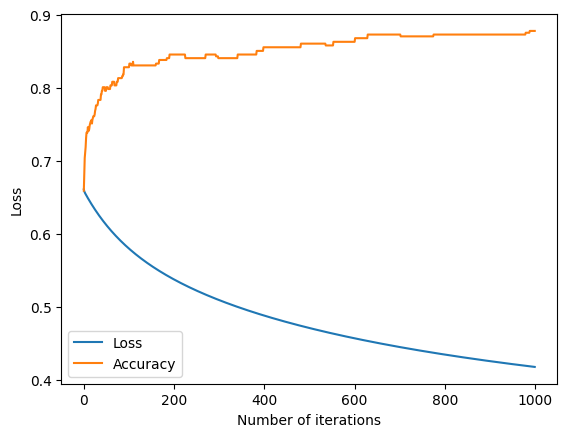

In [51]:
model.plot()

In [52]:
model.eval(
    x=train_features_with_centroid[:, : round(number=best_position[0])],
    y=y_train,
)

Accuracy: 0.8781094527363185
Loss: 0.41779235755339084
F1 Score: 0.8946236559139785
Precision: 0.8221343873517787
Recall: 0.9811320754716981


In [53]:
model.eval(
    x=test_features_with_centroid[:, : round(number=best_position[0])],
    y=y_test,
)

Accuracy: 0.8323699421965318
Loss: 0.41779235755339084
F1 Score: 0.8379888268156425
Precision: 0.7352941176470589
Recall: 0.974025974025974


In [54]:
print(
    classification_report(
        y_true=y_test,
        y_pred=model.predict(
            x=test_features_with_centroid[:, : round(number=best_position[0])]
        ).round(),
    )
)

              precision    recall  f1-score   support

           0       0.97      0.72      0.83        96
           1       0.74      0.97      0.84        77

    accuracy                           0.83       173
   macro avg       0.85      0.85      0.83       173
weighted avg       0.87      0.83      0.83       173



# Feature Reduction


In [55]:
class LDA:
    def __init__(self) -> None:
        self.w: NDArray[float64] = np.array(object=[])

    def fit(self, X: NDArray[float64], y: NDArray[uint]) -> None:
        m0 = np.mean(a=X[y == 0], axis=0)
        m1 = np.mean(a=X[y == 1], axis=0)
        S0 = np.dot(a=(X[y == 0] - m0).T, b=(X[y == 0] - m0))
        S1 = np.dot(a=(X[y == 1] - m1).T, b=(X[y == 1] - m1))
        Sw = S0 + S1
        self.w = np.dot(a=np.linalg.inv(Sw), b=(m1 - m0))

    def transform(self, X: NDArray[float64]) -> NDArray[float64]:
        result: NDArray[float64] = np.dot(a=X, b=self.w)
        return (result - result.mean()) / result.std()

In [56]:
lda = LDA()

In [57]:
lda.fit(
    X=train_features_with_centroid[:, : round(number=best_position[0])],
    y=y_train,
)

In [58]:
train_features_with_centroid: NDArray[float64] = lda.transform(
    X=train_features_with_centroid[:, : round(number=best_position[0])]
)
test_features_with_centroid: NDArray[float64] = lda.transform(
    X=test_features_with_centroid[:, : round(number=best_position[0])]
)

In [59]:
train_features_with_centroid: NDArray[float64] = train_features_with_centroid.reshape(
    -1, 1
)
test_features_with_centroid: NDArray[float64] = test_features_with_centroid.reshape(
    -1, 1
)

In [60]:
train_features_with_centroid.shape, test_features_with_centroid.shape

((402, 1), (173, 1))

# After Feature Reduction

In [61]:
model = LogisticRegression(verbose=True, lr=best_position[1])

In [62]:
model.fit(x=train_features_with_centroid, y=y_train)


Final Loss: 0.2680852655624567
Final Accuracy: 0.9129353233830846


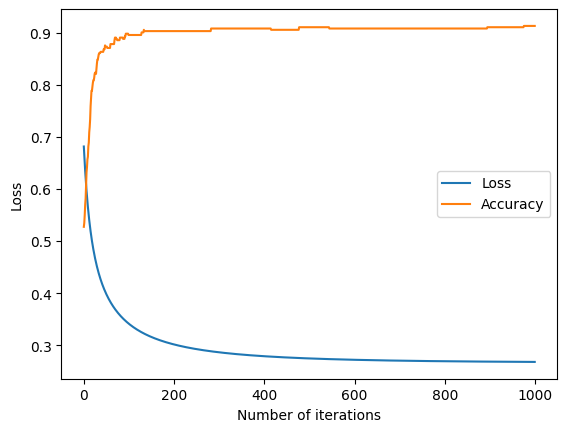

In [63]:
model.plot()

In [64]:
model.eval(x=train_features_with_centroid, y=y_train)

Accuracy: 0.9129353233830846
Loss: 0.2680852655624567
F1 Score: 0.9195402298850575
Precision: 0.8968609865470852
Recall: 0.9433962264150944


In [65]:
model.eval(x=test_features_with_centroid, y=y_test)

Accuracy: 0.8323699421965318
Loss: 0.2680852655624567
F1 Score: 0.8263473053892216
Precision: 0.7666666666666667
Recall: 0.8961038961038961


In [66]:
print(
    classification_report(
        y_true=y_test,
        y_pred=model.predict(x=test_features_with_centroid).round(),
    )
)

              precision    recall  f1-score   support

           0       0.90      0.78      0.84        96
           1       0.77      0.90      0.83        77

    accuracy                           0.83       173
   macro avg       0.84      0.84      0.83       173
weighted avg       0.84      0.83      0.83       173

